In [1]:
########################################################################
#####                   DREAM - MPPC Recording                     #####
########################################################################

In [1]:
##### Import Libraries
import numpy as np
import pandas as pd
import time
import os
import pickle
import matplotlib.pyplot as plt
import datetime
from mcculw import ul
from ctypes import cast, POINTER, c_double, c_ushort, c_ulong 
from mcculw.enums import (ScanOptions, FunctionType, Status, ChannelType, 
    DigitalPortType, ULRange, TriggerSource, TriggerSensitivity, TriggerEvent, 
    DigitalIODirection, TimerIdleState, PulseOutOptions, TrigType)
from mcculw.device_info import DaqDeviceInfo

try:
    from console_examples_util import config_first_detected_device
except ImportError:
    from console_examples_util import config_first_detected_device

In [2]:
########################################################
##### SETUP EQUIPMENT

##### Connect to the DAQ Card
board_num = 0
daq_dev_info = DaqDeviceInfo(board_num = 0)

##### Setup DAQ for analog input
ai_info = daq_dev_info.get_ai_info()
ai_range = ai_info.supported_ranges[2]

In [3]:
## Set the scan options
#scan_options_AI = ScanOptions.BACKGROUND  | ScanOptions.EXTTRIGGER
scan_options_AI = ScanOptions.BACKGROUND

In [4]:
acquisition_settings = {
    'frequency': [128, 64, 32, 16, 8, 4, 2, 1, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125],
    'time_DAQ': [0.75, 1.5, 3, 6, 12, 24, 48, 96, 192, 384, 448, 896, 992, 1152, 2304],
    'DAQ_rate': [1280, 640, 320, 160, 80, 40, 20, 10, 5, 2.5, 1.25, 0.625, 0.3125, 0.15625, 0.078125]
}
acquisition_settings = pd.DataFrame(acquisition_settings)
acquisition_settings

,frequency,time_DAQ,DAQ_rate
0,128.000000,0.75,1280.000000
1,64.000000,1.50,640.000000
2,32.000000,3.00,320.000000
3,16.000000,6.00,160.000000
4,8.000000,12.00,80.000000
5,4.000000,24.00,40.000000
6,2.000000,48.00,20.000000
7,1.000000,96.00,10.000000
8,0.500000,192.00,5.000000
9,0.250000,384.00,2.500000


In [4]:
DAQ_Rate = 10 # [Hz]
Exp_Duration = 10 #[s]
total_count = int(DAQ_Rate * Exp_Duration) + 1
EXPNAME = "Test"

In [16]:
DAQ_Rate

10

In [5]:
frequency = 4 # [Hz]

DAQ_Rate = acquisition_settings.loc[acquisition_settings['frequency'] == frequency, 'DAQ_rate'].values[0]
Exp_Duration = acquisition_settings.loc[acquisition_settings['frequency'] == frequency, 'time_DAQ'].values[0]
total_count = int(DAQ_Rate * Exp_Duration) + 1
EXPNAME = f"f_{frequency}_Hz"

In [6]:
total_count

101

In [5]:
## Allocate a buffer for the input

if ai_info.resolution <= 16:
    # Use the win_buf_alloc method for devices with a resolution <= 16
    memhandle_AI = ul.win_buf_alloc(total_count)
    # Convert the memhandle to a ctypes array.
    ctypes_array_AI = cast(memhandle_AI, POINTER(c_ushort))
else:
    # Use the win_buf_alloc_32 method for devices with a resolution > 16
    memhandle_AI = ul.win_buf_alloc_32(total_count)
    # Convert the memhandle to a ctypes array.
    ctypes_array_AI = cast(memhandle_AI, POINTER(c_ulong))

if not memhandle_AI:
    raise Exception('Error: Failed to allocate memory')


## RUN EXPERIMENT

In [8]:
## Start the timer, which will start and pace AO and AI
scan = (board_num, 3, 3, (total_count), DAQ_Rate, ai_range, memhandle_AI, scan_options_AI)

## Wait until AI Finishes
status, curr_count, curr_index = ul.get_status(board_num, FunctionType.AIFUNCTION)
while status != Status.IDLE:
    time.sleep(0.5)
    status, curr_count, curr_index = ul.get_status(
            board_num, FunctionType.AIFUNCTION)

In [9]:
points = []
for i in range(total_count):
    eng_value = ul.to_eng_units(board_num, ai_range, ctypes_array_AI[i])
    points.append(eng_value)
DAQ_signal = np.array(points)
time_stamps = np.arange(0, Exp_Duration + 1/DAQ_Rate, 1/DAQ_Rate)

In [10]:
time_stamps

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. ])

In [11]:
# DataFolderName = "C:/Users/Orlando/ownCloud - ORLANDO Marcelo@mycore.cnrs.fr/Doutorado/Dados experimentais/MCC_DAQ/" + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + "_" + str(EXPNAME)
# os.makedirs(DataFolderName)
# pickle.dump(DAQ_signal, open(DataFolderName + "/MPPCSignal.p", "wb" ))

In [12]:
len(DAQ_signal)

101

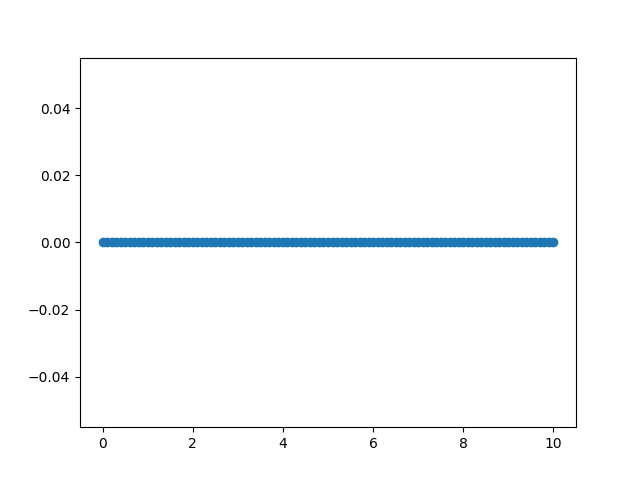

In [13]:
%matplotlib widget
fig, ax = plt.subplots()
ax.plot(time_stamps, DAQ_signal, 'o')